Created on Sunday, April 12, 2020

@author: Himanshu Gupta and Jamie Voros

ASEN 5044 Statistical Estimation, Spring 2020 - Project report 1 

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
from scipy.integrate import odeint
import pdb
from scipy.io import loadmat

In [8]:
#Initializations

x0 = np.array([10,0,np.pi/2,-60,0,-np.pi/2])
u = np.array([2, -np.pi/18, 12, np.pi/25])
v= np.zeros(5).reshape(5,1)
L = 0.5
num_time_steps = 1000
delta_t = 0.1
time_steps = np.linspace(0, num_time_steps*delta_t, num_time_steps)
Qtrue = np.identity(6)*0.01
Rtrue = np.array([
    [0.0225, 0, 0, 0, 0],
    [0, 60, 0, 0, 0],
    [0, 0, 0.04, 0, 0],
    [0, 0, 0, 36, 0],
    [0, 0, 0, 0, 36]
                ])

cholesky_decomposition_Qtrue = np.linalg.cholesky(Qtrue)
cholesky_decomposition_Rtrue = np.linalg.cholesky(Rtrue)


In [10]:
#Generate Nominal trajectory with no noise
def model_nonoise(x, t, u, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g)
    dxdt[1] = v_g*np.sin(theta_g)
    dxdt[2] = (v_g/L)*np.tan(phi_g)
    dxdt[3] = v_a*np.cos(theta_a)
    dxdt[4] = v_a*np.sin(theta_a)
    dxdt[5] = w_a
    return dxdt
#Generate True data with noise

def model(x, t, u, noise, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g) + noise[0][0]
    dxdt[1] = v_g*np.sin(theta_g) + noise[1][0]
    dxdt[2] = (v_g/L)*np.tan(phi_g) + noise[2][0]
    dxdt[3] = v_a*np.cos(theta_a) + noise[3][0]
    dxdt[4] = v_a*np.sin(theta_a) + noise[4][0]
    dxdt[5] = w_a + noise[5][0]
    return dxdt

def calculate_exact_yt(x,v):
    temptop = (x[4]-x[1])
    tempbot = (x[3]-x[0])
    y1 = np.arctan2(temptop,tempbot) - (x[2])
    if y1 < 0:
        y1 = y1 + 2*np.pi
    y1 = y1 - np.pi
    y2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    y3 = np.arctan2(-temptop,-tempbot) - (x[5])
    if y3 < 0:
        y3 = y3 + 2*np.pi
    y4 = x[3]
    y5 = x[4]
    
    yt = np.array([
                [y1],
                [y2],
                [y3],
                [y4],
                [y5]
                ])
    yt = yt + v
    return yt

def get_sample_noise(S):
    n = len(S)
    std_normal_covar_matrix = np.identity(n)
    std_normal_mean_matrix = np.zeros(n)
    sampled_noise_with_covar_I = np.random.multivariate_normal(std_normal_mean_matrix, std_normal_covar_matrix).reshape(n,1)
    sampled_noise_with_covar_Q = np.dot(S,sampled_noise_with_covar_I)
    return sampled_noise_with_covar_Q

def wrap_in_negative_pi_to_pi(theta):
    wrapped_angle = (theta + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

def get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L):
    Xtrue = [x0]
    n = len(x0)
    for i in range(1,len(time_steps)):
        w = get_sample_noise(cholesky_decomposition_Qtrue)
        xk = Xtrue[-1]
        xk_plus1 = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,w,L))
        xk_plus1 = xk_plus1[-1]
        xk_plus1[2] = wrap_in_negative_pi_to_pi(xk_plus1[2])
        xk_plus1[5] = wrap_in_negative_pi_to_pi(xk_plus1[5])
        xk_plus1 = xk_plus1.reshape(n,1)
        Xtrue.append(xk_plus1)    
    return Xtrue

def get_Ytrue(Xtrue,cholesky_decomposition_Rtrue):
    Ytrue = []
    n = len(Xtrue[0])
    for i in range(0,len(Xtrue)):
        v = get_sample_noise(cholesky_decomposition_Rtrue)
        yk = calculate_exact_yt(Xtrue[i].reshape(n,),v)
        Ytrue.append(yk)    
    return Ytrue

observed_state_trajectory = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
observed_state_measurements = get_Ytrue(observed_state_trajectory,cholesky_decomposition_Rtrue)

nominal_state_trajectory = odeint(model_nonoise, x0, time_steps, args = (u,L))
for i in range(0,len(nominal_state_trajectory)):
    theta_g = nominal_state_trajectory[i][2]
    theta_g = (theta_g + np.pi) % (2 * np.pi) - np.pi
    nominal_state_trajectory[i][2] = theta_g
    theta_a = nominal_state_trajectory[i][5]
    theta_a = (theta_a + np.pi) % (2 * np.pi) - np.pi
    nominal_state_trajectory[i][5] = theta_a
    
nominal_state_measurements = []
for i in range(0,len(nominal_state_trajectory)):
    nominal_state_measurements.append(calculate_exact_yt(nominal_state_trajectory[i],v))

In [11]:
def get_CT_Jacobians(x,u):
    
    A = np.array([
            [0, 0, -u[0]*np.sin(x[2]), 0, 0, 0],
            [0, 0, u[0]*np.cos(x[2]), 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -u[2]*np.sin(x[5])],
            [0, 0, 0, 0, 0, u[2]*np.cos(x[5])],
            [0, 0, 0, 0, 0, 0]])

    
    B = np.array([
            [np.cos(x[2]), 0, 0, 0],
            [np.sin(x[2]), 0, 0, 0],
            [np.tan(u[1])/L, u[0]/(L*(np.cos(u[1])**2)), 0, 0],
            [0, 0, np.cos(x[5]), 0],
            [0, 0, np.sin(x[5]), 0],
            [0, 0, 0, 1]
            ])    
    
    Ga = np.eye(6)
    
    denominator_1 = 1 + ((x[4]-x[1])/(x[3]-x[0]))**2
    numerator_11 = (x[4]-x[1]) / ((x[3] - x[0])**2)
    C11 = numerator_11/denominator_1
    
    numerator_12 = -1/(x[3]-x[0])
    C12 = numerator_12/denominator_1
    
    C14 = -1*C11
    C15 = -1*C12
    
    denominator_2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    C21 = (x[0]-x[3])/denominator_2
    C22 = (x[1]-x[4])/denominator_2
    C24 = -1*C21
    C25 = -1*C22
    
    C = np.array([
            [C11, C12, -1, C14, C15, 0],
            [C21, C22, 0, C24, C25, 0],
            [C11, C12, 0, C14, C15, -1],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0]
            ])

    D = 0
    
    return A, B, Ga, C, D

def get_DT_Jacobians(x,u,dt):
    
    A,B,Gamma,C,D = get_CT_Jacobians(x,u)
    
    F = np.eye(6) + dt*A
    G = dt*B
    Omega = delta_t*Gamma
    H = C
    M = D
    
    return F,G,Omega,H,M

In [34]:
def k_matrix(P, H, R):
    PHt = np.matmul(P, np.transpose(H))
    HPHt = np.matmul(H, PHt)
    HPHt_R_inv = np.linalg.inv(HPHt + R)
    K = np.matmul(PHt, HPHt_R_inv)
    return K
    
    
def linear_kalman_filter(F, x, y, G, u, P, Q, H, R, Omega):
    x_predicted = np.dot(F,x) + np.dot(G,u)
    FP = np.matmul(F,P)
    P_predicted = np.matmul(FP,np.transpose(F)) + np.matmul(np.matmul(Omega,Q),np.transpose(Omega))
    K = k_matrix(P_predicted, H, R)
    error = y - np.dot(H,x_predicted)
    x = x_predicted + np.dot(K,error)
    P_update = np.identity(len(P)) - np.matmul(K,H)
    P = np.matmul(P_update,P_predicted)
    
    return x, P, P_predicted

In [77]:
all_data = loadmat('data.mat')
y_data = all_data['ydata']
y_observed = []
for i in range(1,len(y_data[1,:])):
    y_observed.append(np.transpose([y_data[:,i]]))

In [41]:
def get_K_perturbations_LKF(initial_perturbation,nominal_state_trajectory,u,delta_t,K,P,R,Q):
    
    delta_x0 = np.array(initial_perturbation).reshape(len(initial_perturbation),1) 
    delta_x_list = []
    delta_y_list = []
    P_list = []
    innovation_list = []
    delta_xk = delta_x0 
    delta_uk = np.zeros(4).reshape(4,1)
    Pk = P
    for k in range(0,K):
        delta_x_list.append(delta_xk)
        xk_nominal = nominal_state_trajectory[k]
        uk_nominal = u
        Fk,Gk,Omegak,Hk,Mk = get_DT_Jacobians(xk_nominal,uk_nominal,delta_t)
        delta_yk = observed_state_measurements[k] - nominal_state_measurements[k]
        delta_xk_plus1, Pk, P_predicted = linear_kalman_filter(Fk, delta_xk, delta_yk, Gk, delta_uk, Pk, Q, Hk, R, Omegak)
        delta_y_list.append(delta_yk)
        innovation_list.append(Pk)
        P_list.append(P_predicted)
        delta_xk = delta_xk_plus1
        
    return delta_x_list,delta_y_list, P_list, innovation_list


P = np.identity(6)
#initial_perturbation = 0.05*np.ones(len(x0))
initial_perturbation = np.array([0,1,0,0,0,0.1])
#delta_x_LKF_list, delta_y_LKF_list = get_K_perturbations_LKF(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue)

In [37]:
def get_estimated_states_and_measurements(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue,nominal_state_measurements):
    delta_x_LKF_list, delta_y_LKF_list, estimated_covariance_matrix_list, innovation_covariance_matrix_list = get_K_perturbations_LKF(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue)
    estimated_state_list = []
    for k in range(0,len(nominal_state_trajectory)):
        xk = nominal_state_trajectory[k].reshape(len(nominal_state_trajectory[k]),1) + delta_x_LKF_list[k]
        estimated_state_list.append(xk)
    
    estimated_measurement_list = []
    for k in range(0,len(nominal_state_measurements)):
        yk = nominal_state_measurements[k] + delta_y_LKF_list[k]
        estimated_measurement_list.append(yk)
        
    return estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list


In [38]:
non_linear_trajectory_with_perturbed_x0 = odeint(model_nonoise, x0+initial_perturbation, time_steps, args = (u,L))
for i in range(0,len(non_linear_trajectory_with_perturbed_x0)):
    theta_g = non_linear_trajectory_with_perturbed_x0[i][2]
    theta_g = (theta_g + np.pi) % (2 * np.pi) - np.pi
    non_linear_trajectory_with_perturbed_x0[i][2] = theta_g
    theta_a = non_linear_trajectory_with_perturbed_x0[i][5]
    theta_a = (theta_a + np.pi) % (2 * np.pi) - np.pi
    non_linear_trajectory_with_perturbed_x0[i][5] = theta_a

non_linear_measurements_with_perturbed_x0 = []
for i in range(0,len(non_linear_trajectory_with_perturbed_x0)):
    non_linear_measurements_with_perturbed_x0.append(calculate_exact_yt(non_linear_trajectory_with_perturbed_x0[i],v))

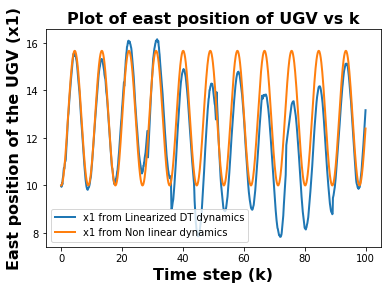

In [21]:
#Plot x[1] or east position of UGV

linearized_DT_x1 = []
non_linear_x1 = []

for state in linearized_DT_states_LKF:
    linearized_DT_x1.append(state[0][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x1.append(state[0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UGV (x1)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x1,linewidth = 2,label = 'x1 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x1,linewidth = 2,label = 'x1 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



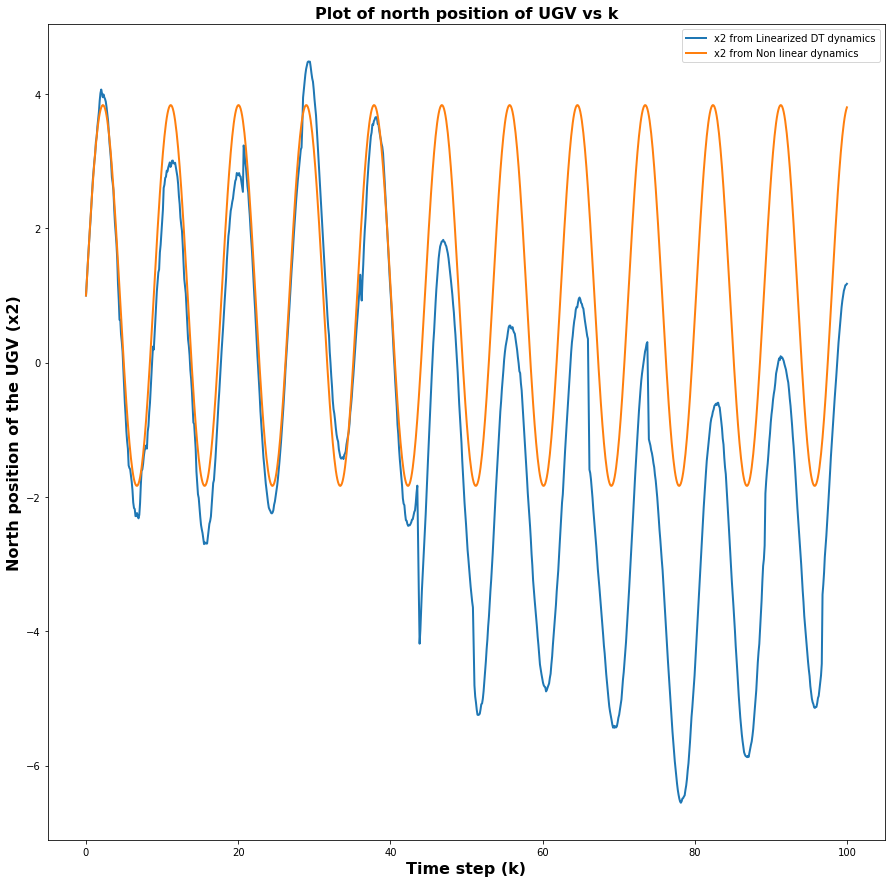

In [22]:
#Plot x[2] or north position of UGV

linearized_DT_x2 = []
non_linear_x2 = []

for state in linearized_DT_states_LKF:
    linearized_DT_x2.append(state[1][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x2.append(state[1])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UGV (x2)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x2,linewidth = 2,label = 'x2 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x2,linewidth = 2,label = 'x2 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



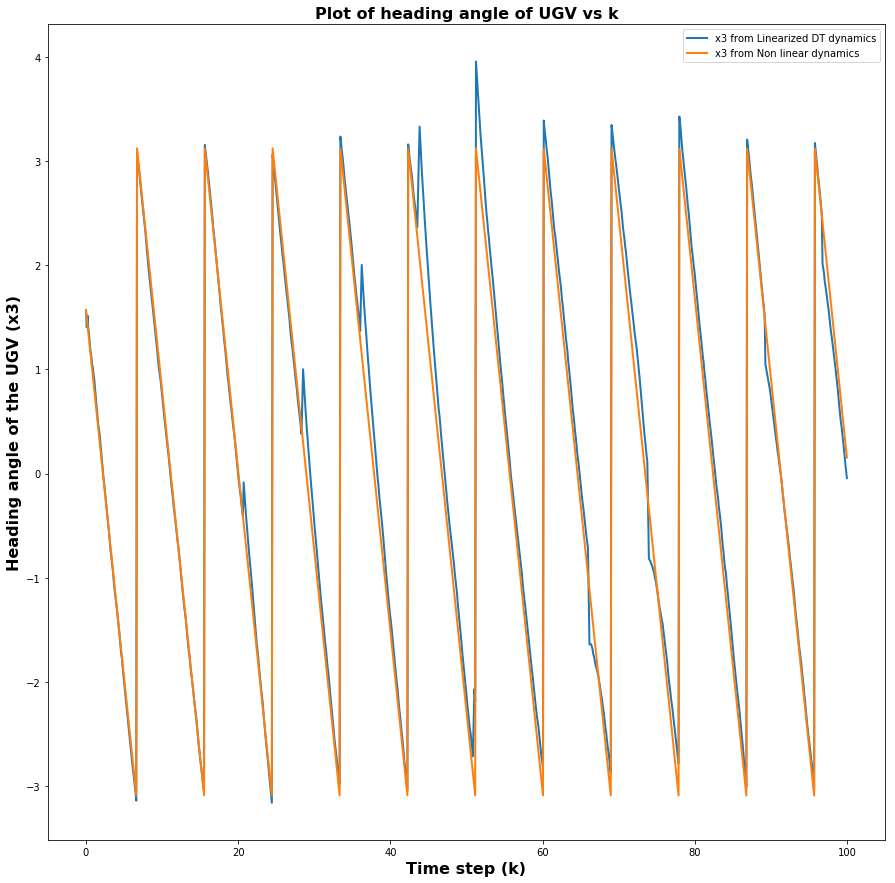

In [23]:
#Plot x[3] or heading angle of UGV

linearized_DT_x3 = []
non_linear_x3 = []

for state in linearized_DT_states_LKF:
    linearized_DT_x3.append(state[2][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x3.append(state[2])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UGV (x3)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x3,linewidth = 2,label = 'x3 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x3,linewidth = 2,label = 'x3 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



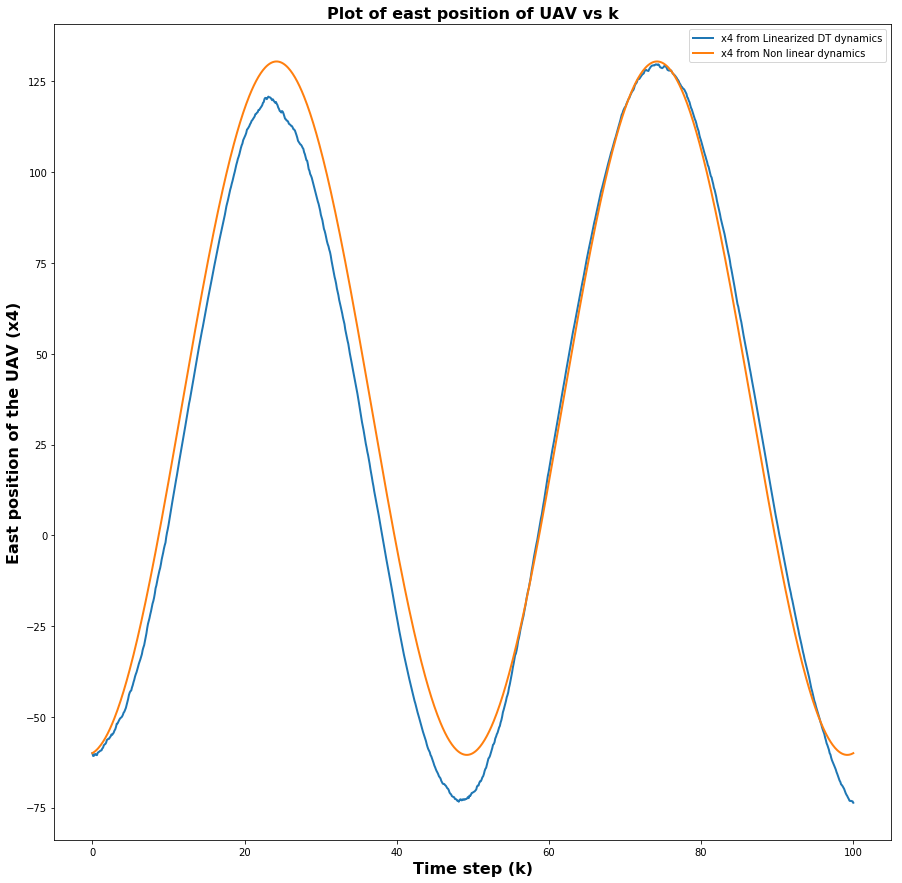

In [24]:
#Plot x[4] or east position of UAV

linearized_DT_x4 = []
non_linear_x4 = []

for state in linearized_DT_states_LKF:
    linearized_DT_x4.append(state[3][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x4.append(state[3])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UAV (x4)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x4,linewidth = 2,label = 'x4 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x4,linewidth = 2,label = 'x4 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



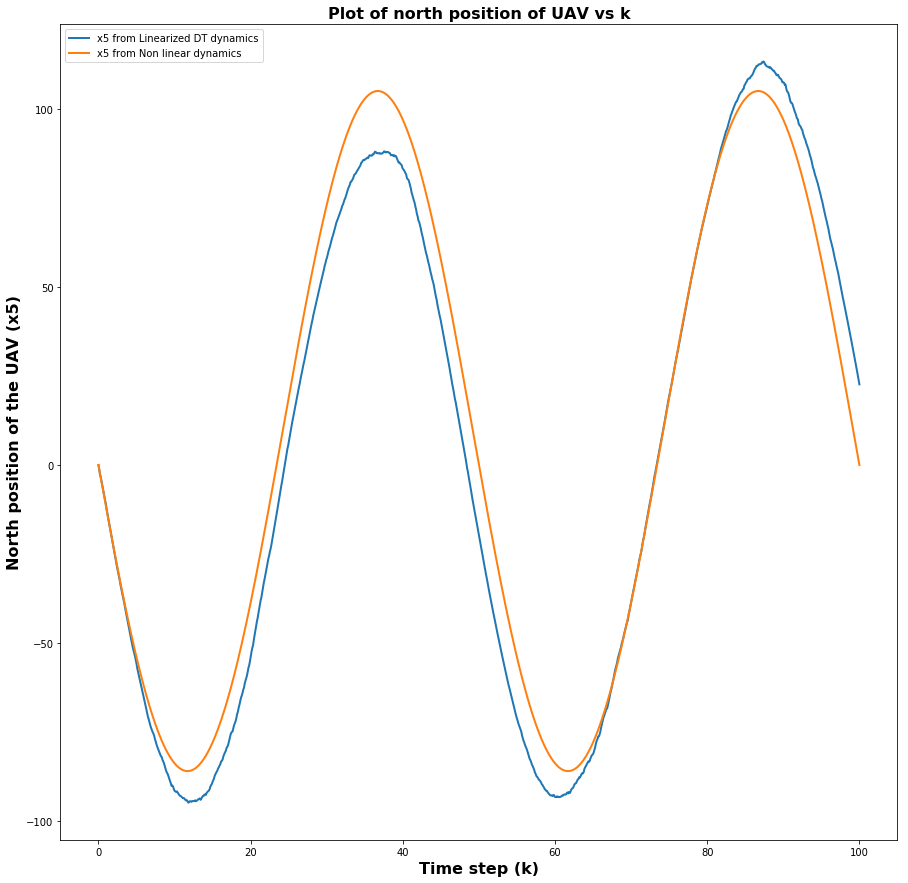

In [25]:
#Plot x[5] or north position of UAV

linearized_DT_x5 = []
non_linear_x5 = []

for state in linearized_DT_states_LKF:
    linearized_DT_x5.append(state[4][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x5.append(state[4])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UAV (x5)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x5,linewidth = 2,label = 'x5 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x5,linewidth = 2,label = 'x5 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



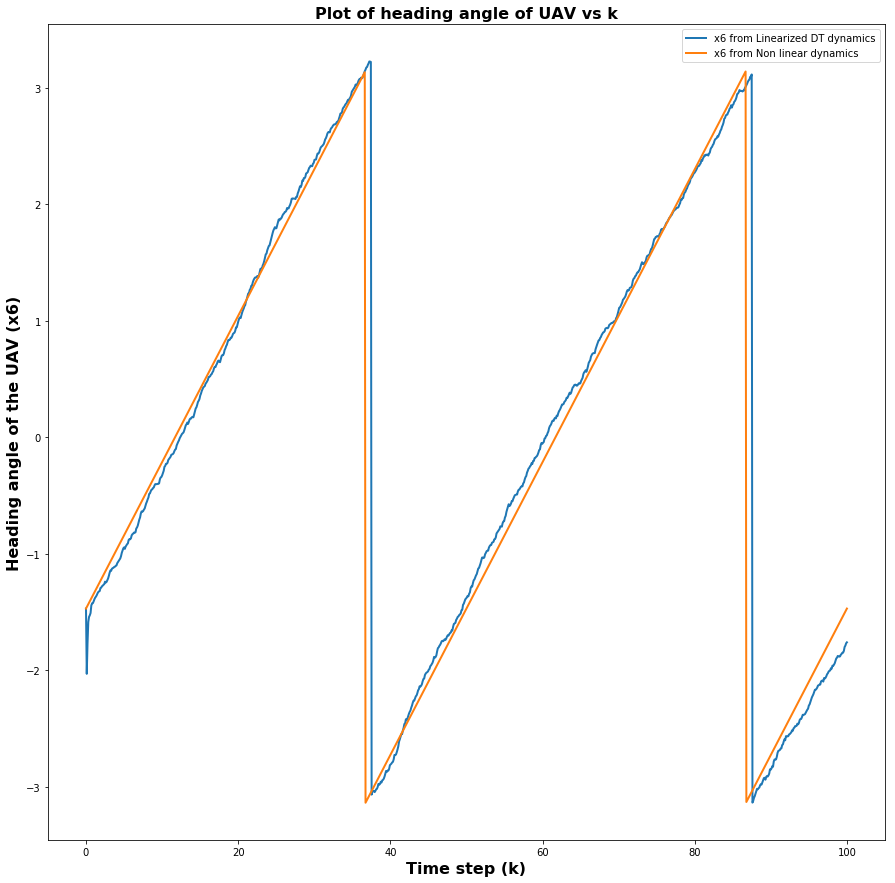

In [26]:
#Plot x[6] or heading angle of UAV

linearized_DT_x6 = []
non_linear_x6 = []

for state in linearized_DT_states_LKF:
    linearized_DT_x6.append(state[5][0])
    
for state in non_linear_trajectory_with_perturbed_x0:
    non_linear_x6.append(state[5])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UAV (x6)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_x6,linewidth = 2,label = 'x6 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_x6,linewidth = 2,label = 'x6 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



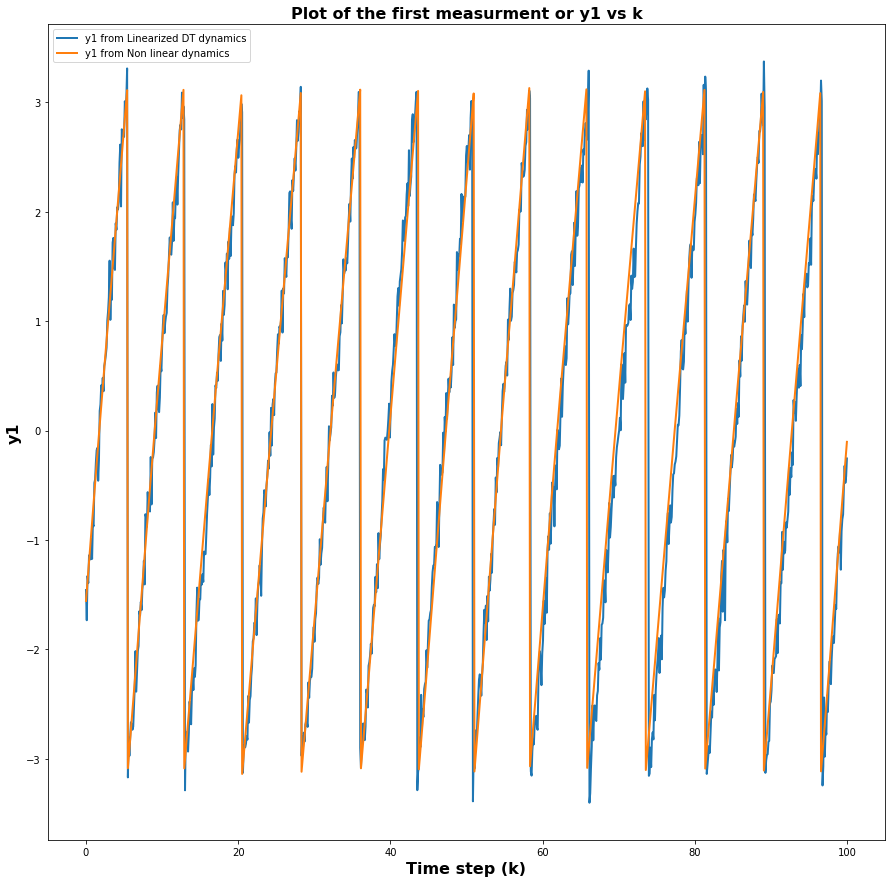

In [27]:
#Plot y[1]

linearized_DT_y1 = []
non_linear_y1 = []

for state in linearized_DT_measurements_LKF:
    linearized_DT_y1.append(state[0][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y1.append(state[0][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y1",fontsize=16, fontweight='bold')
plt.title("Plot of the first measurment or y1 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y1,linewidth = 2,label = 'y1 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y1,linewidth = 2,label = 'y1 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



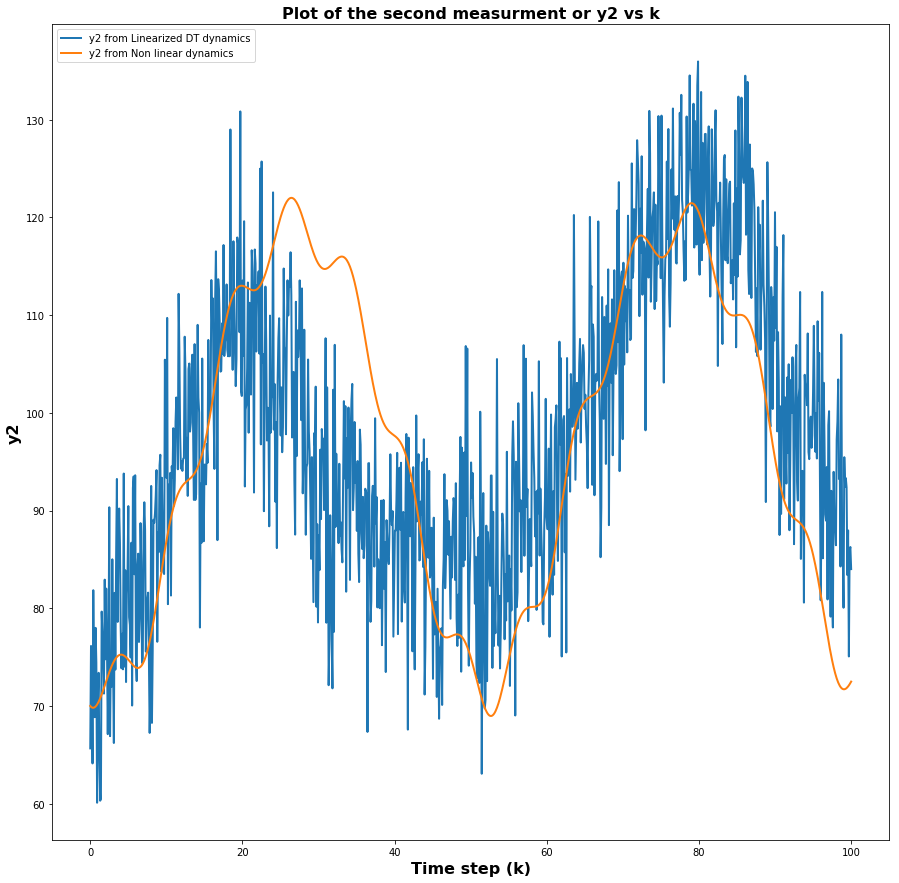

In [28]:
#Plot y[2]

linearized_DT_y2 = []
non_linear_y2 = []

for state in linearized_DT_measurements_LKF:
    linearized_DT_y2.append(state[1][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y2.append(state[1][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y2",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y2 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y2,linewidth = 2,label = 'y2 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y2,linewidth = 2,label = 'y2 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



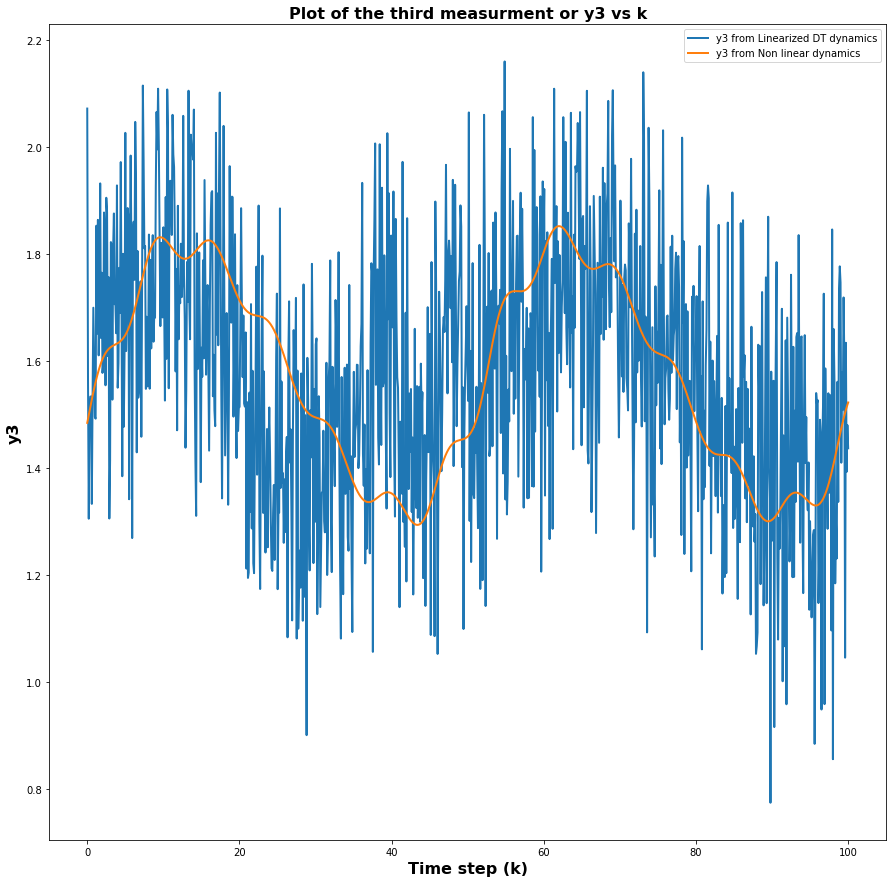

In [29]:
#Plot y[3]

linearized_DT_y3 = []
non_linear_y3 = []

for state in linearized_DT_measurements_LKF:
    linearized_DT_y3.append(state[2][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y3.append(state[2][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y3",fontsize=16, fontweight='bold')
plt.title("Plot of the third measurment or y3 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y3,linewidth = 2,label = 'y3 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y3,linewidth = 2,label = 'y3 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



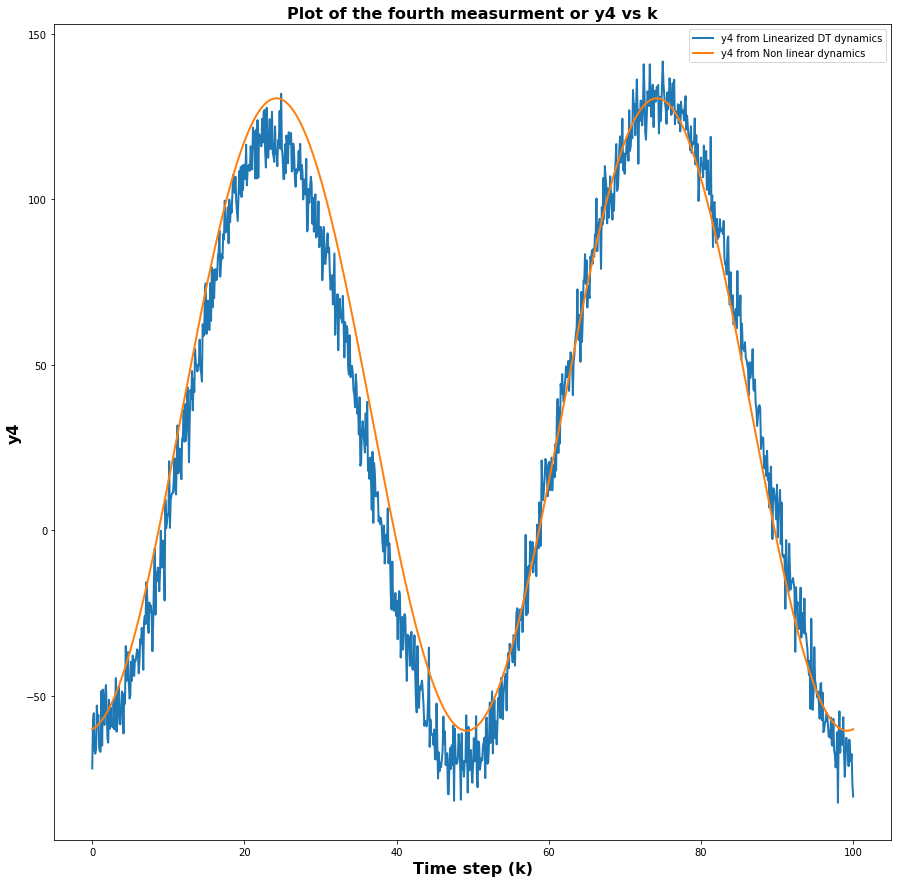

In [30]:
#Plot y[4]

linearized_DT_y4 = []
non_linear_y4 = []

for state in linearized_DT_measurements_LKF:
    linearized_DT_y4.append(state[3][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y4.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y4",fontsize=16, fontweight='bold')
plt.title("Plot of the fourth measurment or y4 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y4,linewidth = 2,label = 'y4 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y4,linewidth = 2,label = 'y4 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



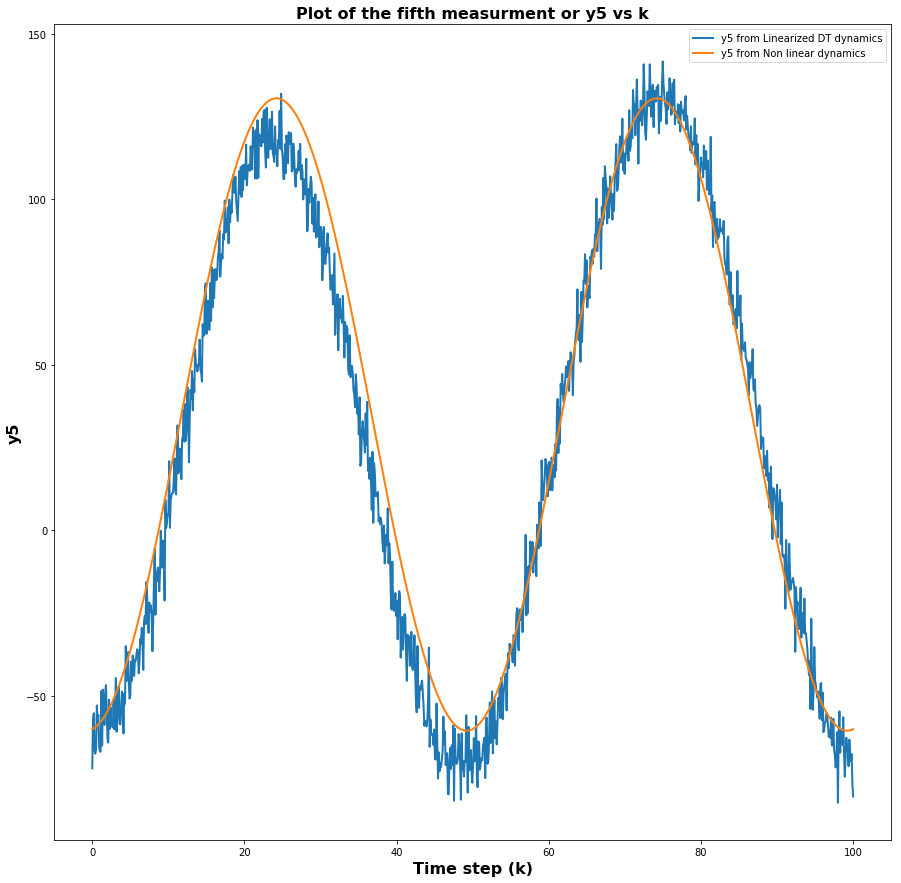

In [31]:
#Plot y[5]

linearized_DT_y5 = []
non_linear_y5 = []

for state in linearized_DT_measurements_LKF:
    linearized_DT_y5.append(state[3][0])
    
for state in non_linear_measurements_with_perturbed_x0:
    non_linear_y5.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y5",fontsize=16, fontweight='bold')
plt.title("Plot of the fifth measurment or y5 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,linearized_DT_y5,linewidth = 2,label = 'y5 from Linearized DT dynamics')
plt.plot(time_steps,non_linear_y5,linewidth = 2,label = 'y5 from Non linear dynamics')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()



In [45]:
#NEES and NIS

def get_weighted_error_x_at_step_k(actual_x,estimated_x,Pk):
    ek = actual_x - estimated_x
    epsilon = np.dot(ek.transpose(),np.dot(np.linalg.inv(Pk),ek))
    return epsilon[0][0]

def get_epsilon_x_for_all_time_steps_in_one_simulation(actual_x_list, estimated_x_list, estimated_P_list):
    epsilon_x_list = []
    for k in range(0,len(actual_x_list)):
        epsilon_at_step_k = get_weighted_error_x_at_step_k(actual_x_list[k],estimated_x_list[k],estimated_P_list[k])
        epsilon_x_list.append(epsilon_at_step_k)
        
    return epsilon_x_list

def get_weighted_error_y_at_step_k(actual_y,estimated_y,Sk):
    ek = actual_y - estimated_y
    epsilon = np.dot(ek.transpose(),np.dot(np.linalg.inv(Sk),ek))
    return epsilon[0][0]

def get_epsilon_y_for_all_time_steps_in_one_simulation(actual_y_list, estimated_y_list, estimated_S_list):
    epsilon_y_list = []
    for k in range(0,len(actual_y_list)):
        epsilon_at_step_k = get_weighted_error_y_at_step_k(actual_y_list[k],estimated_y_list[k],estimated_S_list[k])
        epsilon_y_list.append(epsilon_at_step_k)
        
    return epsilon_y_list

def get_NEES_data_for_multiple_simulations(x0,P0,u,Qtrue,Rtrue,Qfilter,Rfilter,num_mc_simulations):
    NEES_data = np.zeros(shape=(num_mc_simulations,1001))
    NIS_data = np.zeros(shape=(num_mc_simulations,1000))
    cholesky_decomposition_Q = np.linalg.cholesky(Qtrue)
    cholesky_decomposition_R = np.linalg.cholesky(Rtrue)
    
    for i in range(0,num_mc_simulations):
        print("Performing simulation number " + str(i))
        Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Q,L)
        Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_R)

        estimated_state_list,estimated_covariance_matrix_list,\
        estimated_measurement_list,innovation_covariance_matrix_list = \
        get_estimated_states_and_measurements(initial_perturbation, nominal_state_trajectory, u, delta_t, num_time_steps,P,Rtrue,Qtrue,nominal_state_measurements)
        epsilon_x_for_all_time_steps_in_one_simulation = \
        get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list, \
                                                           estimated_covariance_matrix_list)
        
        epsilon_y_for_all_time_steps_in_one_simulation = get_epsilon_y_for_all_time_steps_in_one_simulation \
        (Ytrue[1:],estimated_measurement_list, innovation_covariance_matrix_list)

        
        NEES_data[i] = np.array(epsilon_x_for_all_time_steps_in_one_simulation)
        NIS_data[i] = np.array(epsilon_y_for_all_time_steps_in_one_simulation)
        
    return NEES_data,NIS_data

NEES_data,NIS_data = get_NEES_data_for_multiple_simulations(x0,Qtrue,u,(999999)*Qtrue,Rtrue,Qtrue,Rtrue,3)

Performing simulation number 0


ValueError: shapes (6,6) and (5,1) not aligned: 6 (dim 1) != 5 (dim 0)